# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [45]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [46]:
bulkPath = '../nf_output_JG024/countData/countData.tsv'
metaPath = '../SraRunTable_JG024.csv' # metadata from SRA
gffPath = '../nf_output_JG024/alignments/dualGenome.gff3' # output from nf pipeline

In [47]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

#acc_drop = metadata[metadata["genotype"] == "rpoC G17D"]["Run"].tolist()
#acc_drop = [acc + "_sorted.bam" for acc in acc_drop]
#df_initial.drop(columns=acc_drop, inplace=True)
#metadata = metadata[metadata['genotype'] == 'WT']

In [48]:
df_initial

,Chr,Start,End,Strand,Length,SRR29715794_sorted.bam,SRR29715795_sorted.bam,SRR29715801_sorted.bam,SRR29715800_sorted.bam
Geneid,,,,,,,,,
gene-PA0001,AE004091.2,483,2027,+,1545,1277,1288,606,1419
gene-PA0002,AE004091.2,2056,3159,+,1104,698,800,435,946
gene-PA0003,AE004091.2,3169,4278,+,1110,832,1107,512,1389
gene-PA0004,AE004091.2,4275,6695,+,2421,1181,1452,988,1923
gene-PA0005,AE004091.2,7018,7791,-,774,148,189,65,163
...,...,...,...,...,...,...,...,...,...
gene-F358_gp89,NC_017674.1,64622,64837,-,216,1525,1577,697,1698
gene-F358_gp90,NC_017674.1,64834,65058,-,225,4530,4243,1200,2653
gene-F358_gp91,NC_017674.1,65031,65282,-,252,19925,20228,4418,12378


In [49]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,treatment
0,SRR29715794,RNA-Seq,101,1220529349,PRJNA1132182,SAMN42336978,429821349,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218155,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379008,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:41:00Z,1,GSM8379008,bacterial + phage,SRP518165,JG024 24 min
1,SRR29715795,RNA-Seq,101,1234177075,PRJNA1132182,SAMN42336979,462717895,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218154,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379007,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:42:00Z,1,GSM8379007,bacterial + phage,SRP518165,JG024 24 min
2,SRR29715800,RNA-Seq,101,1640164250,PRJNA1132182,SAMN42336984,594930106,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218149,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379002,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:42:00Z,1,GSM8379002,bacterial + phage,SRP518165,JG024 8 min
3,SRR29715801,RNA-Seq,101,1372669083,PRJNA1132182,SAMN42336985,511257818,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218148,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379001,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:42:00Z,1,GSM8379001,bacterial + phage,SRP518165,JG024 8 min


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [50]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM8379001': '8_R1',  'GSM8379002': '8_R2',
              'GSM8379007': '24_R1',  'GSM8379008': '24_R2'
}

In [51]:
metadataFull = annotateData(metadata, sampleDict)

In [52]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,treatment
0,SRR29715794,RNA-Seq,101,1220529349,PRJNA1132182,SAMN42336978,429821349,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218155,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379008,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:41:00Z,1,GSM8379008,bacterial + phage,SRP518165,JG024 24 min


In [53]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR29715794_sorted.bam,SRR29715794,RNA-Seq,101,1220529349,PRJNA1132182,SAMN42336978,429821349,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218155,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379008,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:41:00Z,1,GSM8379008,bacterial + phage,SRP518165,JG024 24 min,SRR29715794_sorted.bam,24_R2
SRR29715795_sorted.bam,SRR29715795,RNA-Seq,101,1234177075,PRJNA1132182,SAMN42336979,462717895,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218154,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379007,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:42:00Z,1,GSM8379007,bacterial + phage,SRP518165,JG024 24 min,SRR29715795_sorted.bam,24_R1
SRR29715800_sorted.bam,SRR29715800,RNA-Seq,101,1640164250,PRJNA1132182,SAMN42336984,594930106,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218149,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379002,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:42:00Z,1,GSM8379002,bacterial + phage,SRP518165,JG024 8 min,SRR29715800_sorted.bam,8_R2
SRR29715801_sorted.bam,SRR29715801,RNA-Seq,101,1372669083,PRJNA1132182,SAMN42336985,511257818,bacterial + phage,CHARITÉ,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX25218148,wild-type,uncalculated,uncalculated,missing,Illumina HiSeq 1000,GSM8379001,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2024-07-17T00:00:00Z,2024-07-05T14:42:00Z,1,GSM8379001,bacterial + phage,SRP518165,JG024 8 min,SRR29715801_sorted.bam,8_R1


Add correct sample names.

In [54]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['8_R1', '8_R2',
         '24_R1', '24_R2']]
df.head()

SampleNames,8_R1,8_R2,24_R1,24_R2
Geneid,,,,
gene-PA0001,606,1419,1288,1277
gene-PA0002,435,946,800,698
gene-PA0003,512,1389,1107,832
gene-PA0004,988,1923,1452,1181
gene-PA0005,65,163,189,148


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [55]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [56]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_017674.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_017674.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5677,NC_017674.1,RefSeq,gene,25.0,327.0,.,-,.,gene-F358_gp01,F358_gp01,Gene,protein_coding,F358_gp01,gene-F358_gp01,hypothetical protein,hypothetical protein,5721,unknown function
5678,NC_017674.1,RefSeq,gene,383.0,556.0,.,-,.,gene-F358_gp02,F358_gp02,Gene,protein_coding,F358_gp02,gene-F358_gp02,hypothetical protein,hypothetical protein,21072,unknown function
5679,NC_017674.1,RefSeq,gene,607.0,753.0,.,-,.,gene-F358_gp03,F358_gp03,Gene,protein_coding,F358_gp03,gene-F358_gp03,hypothetical protein,hypothetical protein,16325,unknown function
5680,NC_017674.1,RefSeq,gene,931.0,2313.0,.,+,.,gene-F358_gp04,F358_gp04,Gene,protein_coding,F358_gp04,gene-F358_gp04,terminase large subunit,terminase large subunit,3717,head and packaging
5681,NC_017674.1,RefSeq,gene,2350.0,2733.0,.,-,.,gene-F358_gp05,F358_gp05,Gene,protein_coding,F358_gp05,gene-F358_gp05,hypothetical protein,hypothetical protein,5237,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,NC_017674.1,RefSeq,gene,64622.0,64837.0,.,-,.,gene-F358_gp89,F358_gp89,Gene,protein_coding,F358_gp89,gene-F358_gp89,hypothetical protein,hypothetical protein,4985,unknown function
5766,NC_017674.1,RefSeq,gene,64834.0,65058.0,.,-,.,gene-F358_gp90,F358_gp90,Gene,protein_coding,F358_gp90,gene-F358_gp90,hypothetical protein,hypothetical protein,5037,unknown function
5767,NC_017674.1,RefSeq,gene,65031.0,65282.0,.,-,.,gene-F358_gp91,F358_gp91,Gene,protein_coding,F358_gp91,gene-F358_gp91,hypothetical protein,hypothetical protein,5496,unknown function
5768,NC_017674.1,RefSeq,gene,65368.0,65541.0,.,-,.,gene-F358_gp92,F358_gp92,Gene,protein_coding,F358_gp92,gene-F358_gp92,hypothetical protein,hypothetical protein,5856,unknown function


In [57]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'AE004091.2', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [58]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-PA0001,AE004091.2,Genbank,gene,483.0,2027.0,.,+,.,ID=gene-PA0001;Name=dnaA;gbkey=Gene;gene=dnaA;...,gene-PA0001,protein_coding,dnaA,host
gene-PA0002,AE004091.2,Genbank,gene,2056.0,3159.0,.,+,.,ID=gene-PA0002;Name=dnaN;gbkey=Gene;gene=dnaN;...,gene-PA0002,protein_coding,dnaN,host
gene-PA0003,AE004091.2,Genbank,gene,3169.0,4278.0,.,+,.,ID=gene-PA0003;Name=recF;gbkey=Gene;gene=recF;...,gene-PA0003,protein_coding,recF,host
gene-PA0004,AE004091.2,Genbank,gene,4275.0,6695.0,.,+,.,ID=gene-PA0004;Name=gyrB;gbkey=Gene;gene=gyrB;...,gene-PA0004,protein_coding,gyrB,host
gene-PA0005,AE004091.2,Genbank,gene,7018.0,7791.0,.,-,.,ID=gene-PA0005;Name=lptA;gbkey=Gene;gene=lptA;...,gene-PA0005,protein_coding,lptA,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-F358_gp89,NC_017674.1,RefSeq,gene,64622.0,64837.0,.,-,.,ID=gene-F358_gp89;Dbxref=GeneID:14007134;Name=...,gene-F358_gp89,protein_coding,None,phage
gene-F358_gp90,NC_017674.1,RefSeq,gene,64834.0,65058.0,.,-,.,ID=gene-F358_gp90;Dbxref=GeneID:14007135;Name=...,gene-F358_gp90,protein_coding,None,phage
gene-F358_gp91,NC_017674.1,RefSeq,gene,65031.0,65282.0,.,-,.,ID=gene-F358_gp91;Dbxref=GeneID:14007136;Name=...,gene-F358_gp91,protein_coding,None,phage


Perform in silico rRNA depletion.

In [59]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,8_R1,8_R2,24_R1,24_R2
Geneid,,,,
gene-PA1129,2,9,6,10
gene-PA0746,18,26,36,24
gene-PA4188,2,4,3,4
gene-F358_gp32,268,333,1744,2180
gene-PA1455,152,375,542,400


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [60]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [61]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,8_R1,8_R2,24_R1,24_R2,Entity,Symbol
Geneid,,,,,,
gene-PA1129,1.812828,5.244954,3.614495,6.530027,host,gene-PA1129
gene-PA0746,4.702139,5.128273,7.114335,5.340710,host,gene-PA0746
gene-PA4188,0.811002,1.111465,0.870698,1.251998,host,gene-PA4188
gene-F358_gp32,245.174912,231.861708,1221.575653,1707.642486,phage,gene-F358_gp32
gene-PA1455,60.642020,113.688153,165.432644,136.588915,host,fliA
...,...,...,...,...,...,...
gene-PA1372,47.993093,63.748983,72.280523,59.811418,host,gene-PA1372
gene-PA2440,9.677452,11.578628,7.656874,4.347539,host,gene-PA2440
gene-PA3489,18.459237,26.761296,28.505317,35.349853,host,gene-PA3489


In [62]:
# Check gene names unique
len(tpms['Symbol'].unique())

5757

Log2+1 normalization raw counts

In [63]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,8_R1,8_R2,24_R1,24_R2,Entity,Symbol
Geneid,,,,,,
gene-PA1129,1.584963,3.321928,2.807355,3.459432,host,gene-PA1129
gene-PA0746,4.247928,4.754888,5.209453,4.643856,host,gene-PA0746
gene-PA4188,1.584963,2.321928,2.000000,2.321928,host,gene-PA4188
gene-F358_gp32,8.071462,8.383704,10.769011,11.090774,phage,gene-F358_gp32
gene-PA1455,7.257388,8.554589,9.084808,8.647458,host,fliA
...,...,...,...,...,...,...
gene-PA1372,8.438792,9.240791,9.411511,8.977280,host,gene-PA1372
gene-PA2440,5.000000,5.643856,5.044394,4.087463,host,gene-PA2440
gene-PA3489,5.209453,6.129283,6.209453,6.357552,host,gene-PA3489


Log2+1 normalization tpms

In [64]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,8_R1,8_R2,24_R1,24_R2,Entity,Symbol
Geneid,,,,,,
gene-PA1129,1.492021,2.642691,2.206173,2.912655,host,gene-PA1129
gene-PA0746,2.511503,2.615480,3.020473,2.664644,host,gene-PA0746
gene-PA4188,0.856788,1.078244,0.903577,1.171205,host,gene-PA4188
gene-F358_gp32,7.943540,7.863330,10.255708,10.738635,phage,gene-F358_gp32
gene-PA1455,5.945842,6.841573,7.378795,7.104220,host,fliA
...,...,...,...,...,...,...
gene-PA1372,5.614506,6.016786,6.195358,5.926270,host,gene-PA1372
gene-PA2440,3.416495,3.652903,3.113846,2.418875,host,gene-PA2440
gene-PA3489,4.282383,4.795003,4.882903,5.183878,host,gene-PA3489


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [65]:
columnOrder = ['8_R1', '8_R2', 
               '24_R1', '24_R2']

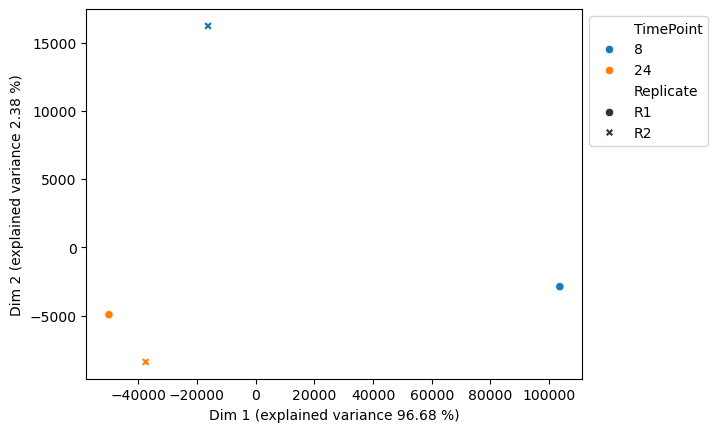

In [66]:
txPCA(tpms[columnOrder])

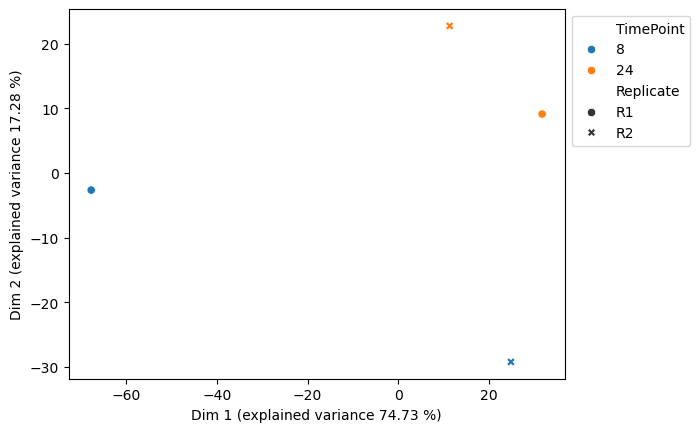

In [67]:
txPCA(logs[columnOrder])

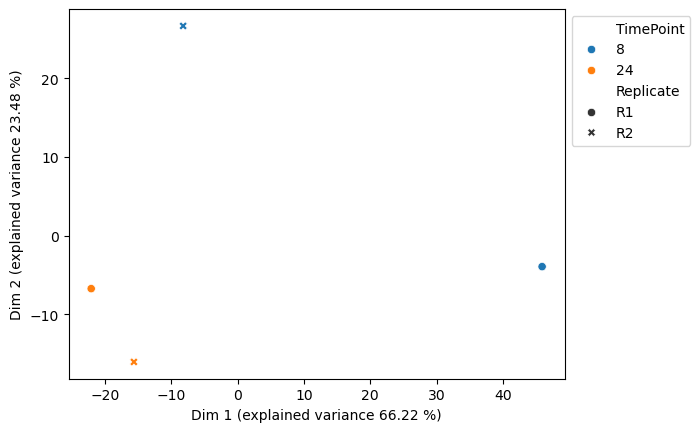

In [68]:
txPCA(logTPMs[columnOrder])

In [69]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

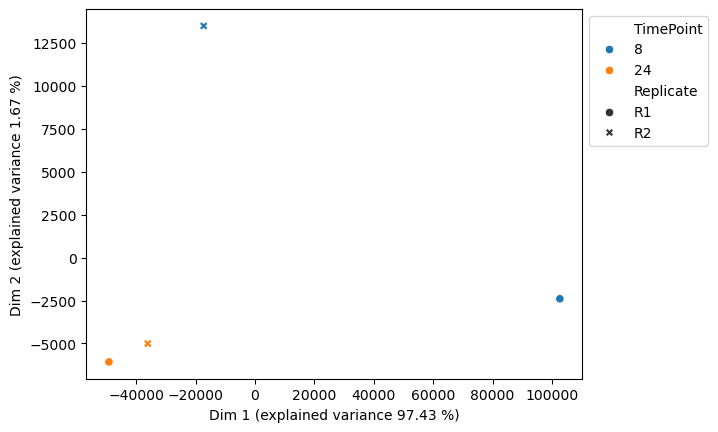

In [70]:
txPCA(tpmHost[columnOrder])

tpmPhage

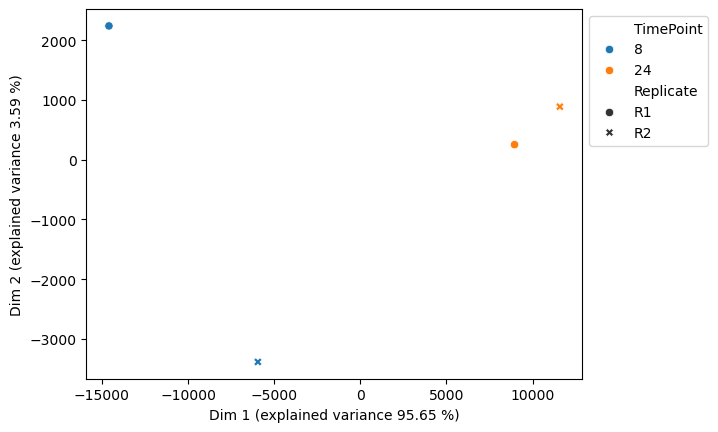

In [71]:
txPCA(tpmPhage[columnOrder])

logTPM Host

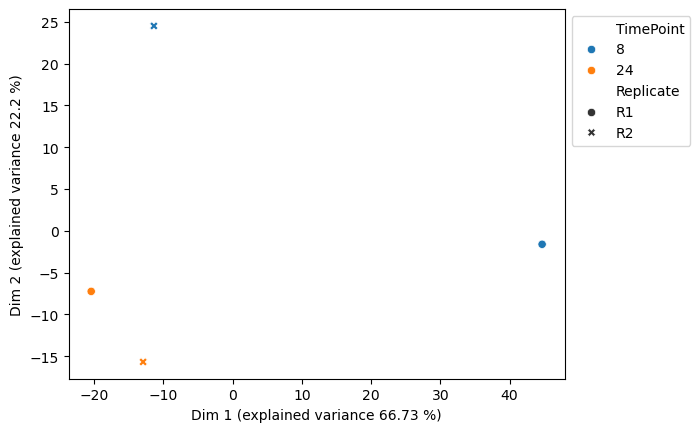

In [72]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

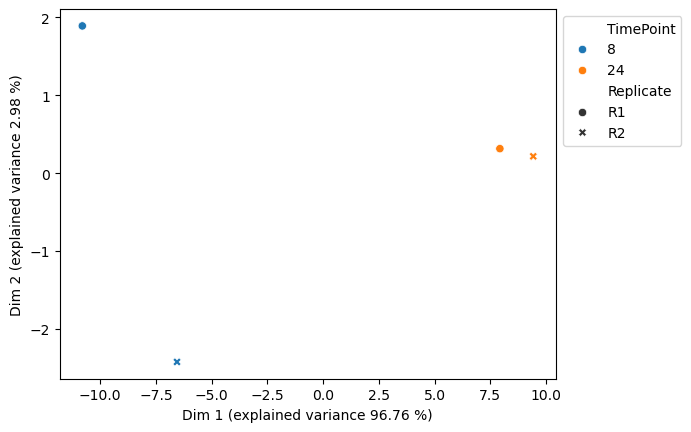

In [73]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ ...

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [74]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['8', '24']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,8,24,Entity,Symbol
Geneid,,,,
gene-PA1129,3.528891,5.072261,host,gene-PA1129
gene-PA0746,4.915206,6.227522,host,gene-PA0746
gene-PA4188,0.961234,1.061348,host,gene-PA4188
gene-F358_gp32,238.518310,1464.609070,phage,gene-F358_gp32
gene-PA1455,87.165086,151.010780,host,fliA
...,...,...,...,...
gene-PA1372,55.871038,66.045970,host,gene-PA1372
gene-PA2440,10.628040,6.002207,host,gene-PA2440
gene-PA3489,22.610267,31.927585,host,gene-PA3489


In [75]:
TPMsds = TPMsds[['8', '24']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,8,24,Entity,Symbol
Geneid,,,,
gene-PA1129,1.716063,1.457766,host,gene-PA1129
gene-PA0746,0.213067,0.886812,host,gene-PA0746
gene-PA4188,0.150232,0.190650,host,gene-PA4188
gene-F358_gp32,6.656602,243.033417,phage,gene-F358_gp32
gene-PA1455,26.523066,14.421865,host,fliA
...,...,...,...,...
gene-PA1372,7.877945,6.234553,host,gene-PA1372
gene-PA2440,0.950588,1.654667,host,gene-PA2440
gene-PA3489,4.151029,3.422268,host,gene-PA3489


In [76]:
propExp = proportionalExp(TPMmeans[['8', '24']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,8,24,Entity,Symbol
Geneid,,,,
gene-PA1129,0.695723,1.000000,host,gene-PA1129
gene-PA0746,0.789272,1.000000,host,gene-PA0746
gene-PA4188,0.905672,1.000000,host,gene-PA4188
gene-F358_gp32,0.162855,1.000000,phage,gene-F358_gp32
gene-PA1455,0.577211,1.000000,host,fliA
...,...,...,...,...
gene-PA1372,0.845942,1.000000,host,gene-PA1372
gene-PA2440,1.000000,0.564752,host,gene-PA2440
gene-PA3489,0.708173,1.000000,host,gene-PA3489


## 5. Phage gene classification

In [77]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [78]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [79]:
TPMmeans

,8,24,Entity,Symbol
Geneid,,,,
gene-PA1129,3.528891,5.072261,host,gene-PA1129
gene-PA0746,4.915206,6.227522,host,gene-PA0746
gene-PA4188,0.961234,1.061348,host,gene-PA4188
gene-F358_gp32,238.518310,1464.609070,phage,gene-F358_gp32
gene-PA1455,87.165086,151.010780,host,fliA
...,...,...,...,...
gene-PA1372,55.871038,66.045970,host,gene-PA1372
gene-PA2440,10.628040,6.002207,host,gene-PA2440
gene-PA3489,22.610267,31.927585,host,gene-PA3489


In [80]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [81]:
TPMmeans["ClassMax"] = None
TPMmeans["ClassThreshold"] = None

In [82]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

Series([], Name: count, dtype: int64)

Add classes to other dfs.

In [83]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'AE004091.2']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_017674.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [84]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [85]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,8_R1,8_R2,24_R1,24_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,
gene-PA1129,1.812828,5.244954,3.614495,6.530027,host,gene-PA1129,None,None,0.727920
gene-PA0746,4.702139,5.128273,7.114335,5.340710,host,gene-PA0746,None,None,0.151931
gene-PA4188,0.811002,1.111465,0.870698,1.251998,host,gene-PA4188,None,None,0.031607
gene-F358_gp32,245.174912,231.861708,1221.575653,1707.642486,phage,gene-F358_gp32,None,None,476.041215
gene-PA1455,60.642020,113.688153,165.432644,136.588915,host,fliA,None,None,12.384124
...,...,...,...,...,...,...,...,...,...
gene-PA1372,47.993093,63.748983,72.280523,59.811418,host,gene-PA1372,None,None,1.252461
gene-PA2440,9.677452,11.578628,7.656874,4.347539,host,gene-PA2440,None,None,0.862327
gene-PA3489,18.459237,26.761296,28.505317,35.349853,host,gene-PA3489,None,None,1.326586


In [86]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [87]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,8_R1,8_R2,24_R1,24_R2,Entity,Symbol
Geneid,,,,,,
gene-PA1129,2,9,6,10,host,gene-PA1129
gene-PA0746,18,26,36,24,host,gene-PA0746
gene-PA4188,2,4,3,4,host,gene-PA4188
gene-F358_gp32,268,333,1744,2180,phage,gene-F358_gp32
gene-PA1455,152,375,542,400,host,fliA
...,...,...,...,...,...,...
gene-PA1372,346,604,680,503,host,gene-PA1372
gene-PA2440,31,49,32,16,host,gene-PA2440
gene-PA3489,36,69,73,81,host,gene-PA3489


In [88]:
# Full TPM table
tpms.to_csv('Bürkle_JG024_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Bürkle_JG024_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Bürkle_JG024_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Bürkle_JG024_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Bürkle_JG024_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Bürkle_JG024_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Bürkle_JG024_phage_gff3.tsv', sep='\t')